## Uso de Programación Lineal para el cálculo de la duración del proyecto y del camino crítico

In [1]:
!apt install libgraphviz-dev              > /dev/null
%pip install pygraphviz "pandas[excel]"   > /dev/null
%pip install numpyarray_to_latex          > /dev/null
%pip install -q amplpy                    > /dev/null

repo_url = 'https://github.com/mcasl/pmULE'
repo_name = "pmULE"

import os, sys

if not os.path.exists(repo_name):
    print(f"Cloning repository '{repo_name}'...")
    !git clone {repo_url}
    print("Repository cloned successfully!")
else:
    print(f"Good! No need to download '{repo_name}' again.")

from google.colab import files

# To find local version of the library
sys.path.append('../src')

from pmule import PredecessorTable, ProjectGraph



Cloning repository 'pmULE'...
Cloning into 'pmULE'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 254 (delta 31), reused 7 (delta 2), pack-reused 191 (from 1)
Receiving objects: 100% (254/254), 9.69 MiB | 20.50 MiB/s, done.
Resolving deltas: 100% (132/132), done.
Repository cloned successfully!


In [2]:
from pmule import *
# Alargamos el ancho de las celdas a un tanto por ciento
from IPython.display import display, HTML, Markdown, Math, Latex
display(HTML("<style>.container { width:60% !important; }</style>"))

import pandas as pd
import numpy as np
import sympy as sym
import matplotlib
import seaborn as sns

datos_enunciado = pd.DataFrame(data=np.array([
       [ 8, 4, 2],
       [10, 5, 4],
       [12, 6, 3],
       [10, 6, 4],
       [ 7, 5, 5],
       [ 7, 4, 5],
       [14, 9, 3],
       [12, 8, 2],
       [10, 7, 1],
       ]),
   columns=['Dmax', 'Dtope', 'UCR'],
   index=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'],
   dtype=np.int32)
datos_enunciado

,Dmax,Dtope,UCR
A,8,4,2
B,10,5,4
C,12,6,3
D,10,6,4
E,7,5,5
F,7,4,5
G,14,9,3
H,12,8,2
I,10,7,1


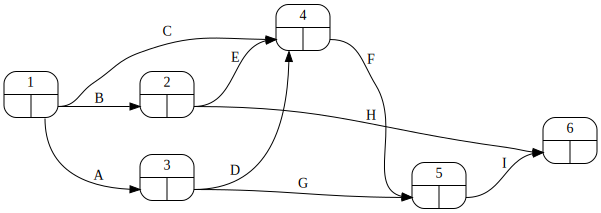

In [3]:
proyecto = ProjectGraph.from_dict_of_strings({
    "A": "---",
    "B": "---",
    "C": "---",
    "D": "A",
    "E": "B",
    "F": "C,D,E",
    "G": "A",
    "H": "B",
    "I": "F,G",
})

proyecto.pert("pert_2024-11-simplex_CriticalPath_no_durations.svg", durations=False, ranksep=1)


## Cálculo de los tiempos tempranos y tardíos por el método de Zaderenko

In [4]:
proyecto.zaderenko(durations=datos_enunciado["Dmax"])


,1,2,3,4,5,6,early
1,,10.0,8.0,12.0,,,0.0
2,,,,7.0,,12.0,10.0
3,,,,10.0,14.0,,8.0
4,,,,,7.0,,18.0
5,,,,,,10.0,25.0
6,,,,,,,35.0
late,0.0,11.0,8.0,18.0,25.0,35.0,


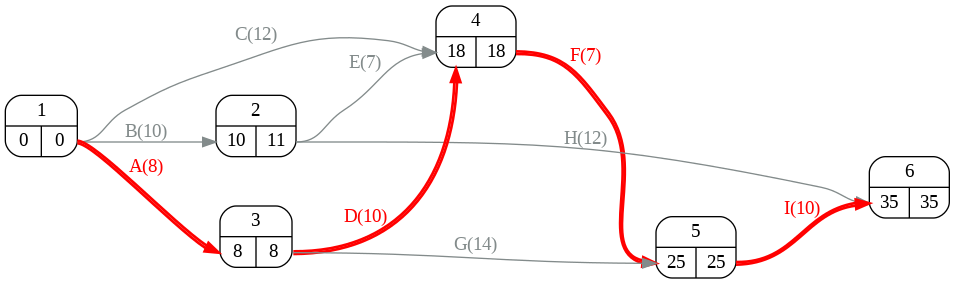

In [5]:
proyecto.pert("pert_2024-11-simplex_CriticalPath_Dmax.png", durations=datos_enunciado["Dmax"], ranksep=1)

## Cálculo de la duración del proyecto mediante Programación Lineal

$$\max z= 8x_A + 10x_B + 12x_C+10x_D+7x_E+7xF+14x_G+12x_H+10x_I$$
sujeto a:

\begin{eqnarray}
1               & = & x_A + x_B + x_C   \\
x_B             & = & x_E + x_H \\
x_A             & = & x_D + x_G \\
x_C+x_E+x_D     & = & x_F \\
x_F+x_G         & = & x_I \\
x_H+x_I         & = & 1 \\
\end{eqnarray}

De manera matricial:

$$\max z= \begin{bmatrix} 8	\\ 10	\\ 	12	\\ 	10	\\ 	7	\\ 	7	\\ 	14	\\ 	12	\\ 	10	\\
  \end{bmatrix}^T \begin{bmatrix}x_A	\\ 	x_B	\\ 	x_C	\\ 	x_D	\\ 	x_E	\\ 	x_F	\\  x_G	\\ 	x_H	\\ 	x_I\end{bmatrix}$$
sujeto a:

$$\begin{bmatrix}
 1  & 1  &  1 &  0 &  0 &  0 &  0 &  0 &  0 \\
 1  & 0  &  0 & -1 &  0 &  0 & -1 &  0 &  0 \\
 0  & 1  &  0 &  0 & -1 &  0 &  0 & -1 &  0 \\
 0  & 0  &  1 &  1 &  1 & -1 &  0 &  0 &  0 \\
 0  & 0  &  0 &  0 &  0 &  1 &  1 &  0 & -1 \\
 0  & 0  &  0 &  0 &  0 &  0 &  0 &  1 &  1 \\
\end{bmatrix}
\begin{bmatrix}x_A	\\ 	x_B	\\ 	x_C	\\ 	x_D	\\ 	x_E	\\ 	x_F	\\  x_G	\\ 	x_H	\\ 	x_I\end{bmatrix}=\begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1\end{bmatrix}$$


### Representación utilizando AMPL

In [6]:
from amplpy import AMPL, ampl_notebook
ampl = ampl_notebook(
    modules=["highs"], # pick from over 20 modules including most commercial and open-source solvers
    license_uuid="default")
    #    license_uuid=userdata.get("licencia_ampl")) # your license UUID (e.g., free ampl.com/ce or ampl.com/courses licenses)

SOLVER = "highs"

Using default Community Edition License for Colab. Get yours at: https://ampl.com/ce
Licensed to AMPL Community Edition License for the AMPL Model Colaboratory (https://ampl.com/colab).


In [7]:
# Sección del modelo
%%ampl_eval

param m;
param n;
param t{1..n};
param b{1..m};
param a{1..m,1..n};

var x{1..n} >= 0;

maximize Duración: sum {j in 1..n} t[j] * x[j];
subject to restr {i in 1..m}:
    sum {j in 1..n}  a[i,j] * x[j] <= b[i];


In [8]:
# Sección de datos
%%ampl_eval
data;
param n:=9;
param m:=6;
param t:= 1 8
          2 10
          3 12
          4 10
          5 7
          6 7
          7 14
          8 12
          9 10;

param b:= 1 1
          2 0
          3 0
          4 0
          5 0
          6 1;

param a:    1  2  3  4  5  6  7  8  9 :=
        1   1  1  1  0  0  0  0  0  0
        2   1  0  0 -1  0  0 -1  0  0
        3   0  1  0  0 -1  0  0 -1  0
        4   0  0  1  1  1 -1  0  0  0
        5   0  0  0  0  0  1  1  0 -1
        6   0  0  0  0  0  0  0  1  1 ;

In [9]:
ampl.option["solver"] = SOLVER
ampl.solve()

HiGHS 1.8.1: HiGHS 1.8.1: optimal solution; objective 35
2 simplex iterations
0 barrier iterations



La duración del proyecto es:

In [10]:
ampl.get_value("Duración")

35

In [11]:
x = pd.Series(ampl.get_solution(zeros=True, flat=False)['x'], name='x')
x

,x
1,1
2,0
3,0
4,1
5,0
6,1
7,0
8,0
9,1


La rama del camino crítico que ha encontrado (puede haber múltiples pero la solución será sólo una de ellas):

In [12]:
[activity for (activity, is_critical) in zip(datos_enunciado.index, x)
                                      if is_critical]

['A', 'D', 'F', 'I']